In [30]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('output/transactions_normalized.csv')

In [5]:
df.head()

,transaction_id,timestamp,type,asset,quantity,price,fees,subtotal,total,currency,source_account,destination_account,institution,transfer_id,matching_institution,matching_date
0,45984b6c-c08f-4608-ba40-98be3505f8ef,2017-11-03 18:59:22.000,buy,BTC,0.003186,7336.77,1.49,23.51,25.0,USD,NaN,NaN,coinbase,NaN,NaN,NaN
1,e5dd051a-be42-49a0-93ea-852916793b19,2017-11-03 19:13:42.000,deposit,USD,50.000000,1.00,0.00,50.00,50.0,USD,NaN,NaN,coinbase,NaN,NaN,NaN
2,9c231e27-f2bd-478a-a70c-2ba13144c203,2017-11-09 22:08:51.000,deposit,USD,500.000000,1.00,0.00,500.00,500.0,USD,NaN,NaN,coinbase,NaN,NaN,NaN
3,21589dec-9205-43cd-9ca1-63b4c279c943,2017-11-09 22:09:43.000,buy,BTC,0.006701,7128.50,1.99,48.01,50.0,USD,NaN,NaN,coinbase,NaN,NaN,NaN
4,5caded1e-3a83-463f-a95d-6c8257a3f971,2017-11-29 20:07:10.000,buy,ETH,0.158807,441.50,2.99,72.01,75.0,USD,NaN,NaN,coinbase,NaN,NaN,NaN


In [25]:
# Create a sorted copy of the DOT DataFrame
df_dot = df[df['asset'] == 'DOT'].copy()
df_dot = df_dot.sort_values(['timestamp'])

# Create mask for non-transfer transactions (transfers shouldn't affect running cost basis)
non_transfer_mask = ~df_dot['type'].isin(['transfer_in', 'transfer_out'])
transfer_mask = df_dot['type'].isin(['transfer_in', 'transfer_out'])

# Initialize running total columns
df_dot['running_quantity'] = 0.0
df_dot['running_subtotal'] = 0.0  # Price paid for assets without fees
df_dot['running_fees'] = 0.0      # Total fees paid for acquiring assets
df_dot['running_total'] = 0.0     # Total cost basis (subtotal + fees)
df_dot['avg_cost_basis'] = 0.0    # Total cost per unit including fees
df_dot['avg_price_per_unit'] = 0.0  # Price per unit excluding fees
df_dot['realized_profit'] = 0.0   # Track realized profit/loss from sells

# Calculate running totals
running_quantity = 0.0
running_subtotal = 0.0  
running_fees = 0.0
running_total = 0.0  # Cost basis
last_avg_cost_basis = 0.0
last_avg_price_per_unit = 0.0
total_realized_profit = 0.0

# Loop through each transaction chronologically
for idx in df_dot.index:
    transaction_type = df_dot.at[idx, 'type']
    quantity = df_dot.at[idx, 'quantity']
    
    # Handle different transaction types
    if transaction_type == 'sell':
        # For sells, calculate realized profit and reduce cost basis proportionally
        
        # Get the values we need
        sell_quantity = abs(quantity)
        sell_subtotal = df_dot.at[idx, 'subtotal'] if pd.notna(df_dot.at[idx, 'subtotal']) else 0.0
        sell_fees = df_dot.at[idx, 'fees'] if pd.notna(df_dot.at[idx, 'fees']) else 0.0
        
        # Net proceeds from sell (subtotal - fees)
        net_proceeds = sell_subtotal - sell_fees
        
        # Proportion of holdings being sold
        proportion_sold = sell_quantity / (running_quantity + sell_quantity)
        
        # Cost basis for the sold portion
        cost_basis_sold = running_total * proportion_sold
        
        # Calculate realized profit/loss
        realized_profit = net_proceeds - cost_basis_sold
        total_realized_profit += realized_profit
        
        # Reduce running totals by the proportion sold
        running_subtotal -= running_subtotal * proportion_sold
        running_fees -= running_fees * proportion_sold
        running_total -= cost_basis_sold
        running_quantity += quantity  # This will reduce quantity since it's negative for sells
        
        # Store the realized profit for this transaction
        df_dot.at[idx, 'realized_profit'] = realized_profit
        
    elif transaction_type in ['buy', 'staking_reward']:
        # For buys and staking rewards, add to our cost basis
        subtotal = df_dot.at[idx, 'subtotal'] if pd.notna(df_dot.at[idx, 'subtotal']) else 0.0
        fees = df_dot.at[idx, 'fees'] if pd.notna(df_dot.at[idx, 'fees']) else 0.0
        
        # Update running totals
        running_subtotal += subtotal
        running_fees += fees  # Include fees in cost basis for buys
        running_total = running_subtotal + running_fees
        running_quantity += quantity
        
    elif transaction_type in ['transfer_in', 'transfer_out']:
        # For transfers, just update quantity but maintain the same cost basis
        running_quantity += quantity
    
    # Update values in DataFrame
    df_dot.at[idx, 'running_quantity'] = running_quantity
    df_dot.at[idx, 'running_subtotal'] = running_subtotal
    df_dot.at[idx, 'running_fees'] = running_fees
    df_dot.at[idx, 'running_total'] = running_total
    
    # Calculate average cost metrics
    if running_quantity > 0:
        df_dot.at[idx, 'avg_cost_basis'] = running_total / running_quantity
        df_dot.at[idx, 'avg_price_per_unit'] = running_subtotal / running_quantity
        
        # Update the last values for potential forward-filling
        last_avg_cost_basis = df_dot.at[idx, 'avg_cost_basis']
        last_avg_price_per_unit = df_dot.at[idx, 'avg_price_per_unit']
    else:
        # If no holdings, maintain the last known values
        df_dot.at[idx, 'avg_cost_basis'] = last_avg_cost_basis
        df_dot.at[idx, 'avg_price_per_unit'] = last_avg_price_per_unit

# Display the resulting DataFrame with key columns
df_dot_display = df_dot[['timestamp', 'type', 'quantity', 'price', 'subtotal', 'fees', 'total', 
                        'running_quantity', 'running_subtotal', 'running_fees', 'running_total',
                        'avg_cost_basis', 'avg_price_per_unit', 'realized_profit']]

# Show summary information
print(f"DOT Summary:")
print(f"Current Holdings: {running_quantity:.8f} DOT")
print(f"Total Cost Basis: ${running_total:.2f}")
if running_quantity > 0:
    print(f"Average Cost Per DOT: ${(running_total/running_quantity):.4f}")
else:
    print("No DOT currently held")
print(f"Total Realized Profit/Loss: ${total_realized_profit:.2f}")

# Display the summary DataFrame
df_dot_display.tail(10)

DOT Summary:
Current Holdings: 731.12794514 DOT
Total Cost Basis: $3953.26
Average Cost Per DOT: $5.4071
Total Realized Profit/Loss: $86.89


,timestamp,type,quantity,price,subtotal,fees,total,running_quantity,running_subtotal,running_fees,running_total,avg_cost_basis,avg_price_per_unit,realized_profit
3670,2024-12-09 21:19:42.000,staking_reward,0.040567,8.6100,0.34928,0.143236,0.49252,754.749233,3932.870670,141.521640,4074.392310,5.398339,5.210831,0.000000
3671,2024-12-10 20:54:59.000,staking_reward,0.040667,8.2240,0.33445,0.139165,0.47361,754.789901,3933.205120,141.660805,4074.865925,5.398676,5.210993,0.000000
3673,2024-12-11 21:35:36.000,staking_reward,0.014610,9.0935,0.13286,0.055064,0.18792,754.804511,3933.337980,141.715869,4075.053849,5.398820,5.211068,0.000000
3676,2024-12-12 20:48:27.000,staking_reward,0.068357,9.1505,0.62550,0.258818,0.88431,754.872868,3933.963480,141.974686,4075.938166,5.399503,5.211425,0.000000
3678,2024-12-13 21:34:49.000,staking_reward,0.044985,9.0695,0.40799,0.168738,0.57673,754.917852,3934.371470,142.143424,4076.514894,5.399945,5.211655,0.000000
3680,2024-12-14 21:05:20.000,staking_reward,0.045365,8.4035,0.38122,0.157773,0.53900,754.963217,3934.752690,142.301197,4077.053887,5.400334,5.211847,0.000000
3682,2024-12-15 21:39:28.000,staking_reward,0.045839,8.7775,0.40236,0.167573,0.56993,755.009057,3935.155050,142.468770,4077.623820,5.400761,5.212063,0.000000
3686,2024-12-16 00:46:39.000,sell,-23.973225,9.1235,216.44000,4.060000,212.38000,731.035832,3814.050426,138.084285,3952.134711,5.406212,5.217324,86.890891
3695,2024-12-17 00:59:15.000,staking_reward,0.046044,8.6385,0.39775,0.165662,0.56341,731.081876,3814.448176,138.249947,3952.698123,5.406642,5.217539,0.000000
3699,2024-12-17 22:08:27.000,staking_reward,0.046069,8.6420,0.39813,0.165744,0.56388,731.127945,3814.846306,138.415692,3953.261997,5.407073,5.217755,0.000000


In [34]:
import pandas as pd
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import uuid
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter

def analyze_asset_fifo(df, symbol):
    """
    Analyze an asset using FIFO accounting method for cost basis.
    
    Parameters:
    -----------
    df : DataFrame
        The full transactions DataFrame
    symbol : str
        The asset symbol to analyze (e.g., 'DOT', 'BTC')
        
    Returns:
    --------
    dict
        A dictionary containing analysis results:
        - df_asset: DataFrame with the asset transactions and calculated fields
        - tax_lots: DataFrame with detailed tax lot information
        - lot_usage: DataFrame tracking how lots are used in sales
        - summary: Dictionary with summary statistics
        - figures: Dictionary with matplotlib figures
    """
    # Set visualization style
    plt.style.use('ggplot')
    sns.set_palette("viridis")
    
    # Money formatter for plots
    def money_formatter(x, pos):
        return f'${x:,.2f}'
    
    # Create a sorted copy of the asset DataFrame
    df_asset = df[df['asset'] == symbol].copy()
    if df_asset.empty:
        return {"error": f"No transactions found for {symbol}"}
    
    df_asset = df_asset.sort_values(['timestamp'])
    df_asset['timestamp'] = pd.to_datetime(df_asset['timestamp'])
    
    # Initialize columns for FIFO tracking
    df_asset['fifo_cost_basis'] = 0.0  # Cost basis using FIFO method
    df_asset['fifo_realized_profit'] = 0.0  # Realized profit/loss for sells
    df_asset['remaining_quantity'] = 0.0  # Quantity still held after each transaction
    df_asset['avg_cost_per_unit'] = 0.0  # Average cost per unit at each point
    df_asset['taxable_event'] = False  # Flag for taxable events
    df_asset['short_term'] = False  # Flag for short-term gains
    df_asset['capital_gains'] = 0.0  # Amount of capital gains
    
    # Create a detailed tax lot tracker DataFrame
    lot_columns = ['lot_id', 'purchase_date', 'purchase_price', 'lot_size', 'unit_cost', 
                  'total_cost', 'fees_included', 'remaining_size', 'transaction_id',
                  'acquisition_type', 'fully_consumed', 'last_modified']
    tax_lots = pd.DataFrame(columns=lot_columns)
    
    # Create a DataFrame to track lot usage in sales
    lot_usage_columns = ['sale_id', 'sale_date', 'sale_price', 'lot_id', 'purchase_date', 
                        'purchase_price', 'quantity_used', 'cost_basis_used', 'gain_loss',
                        'portion_of_sale', 'holding_period_days', 'short_term']
    lot_usage = pd.DataFrame(columns=lot_usage_columns)
    
    # Create a queue to track lots in FIFO order
    lots_queue = deque()  # Will store lot_ids
    lot_details = {}  # Will store all details keyed by lot_id
    total_realized_profit = 0.0
    remaining_quantity = 0.0
    total_cost_basis = 0.0
    
    # Process each transaction chronologically
    for idx in df_asset.index:
        transaction_type = df_asset.at[idx, 'type']
        quantity = df_asset.at[idx, 'quantity']
        transaction_date = df_asset.at[idx, 'timestamp']
        transaction_id = df_asset.at[idx, 'transaction_id']
        price = df_asset.at[idx, 'price'] if pd.notna(df_asset.at[idx, 'price']) else 0.0
        
        if transaction_type in ['buy', 'staking_reward']:
            # For buys and staking rewards, add new lot to the queue
            subtotal = df_asset.at[idx, 'subtotal'] if pd.notna(df_asset.at[idx, 'subtotal']) else 0.0
            fees = df_asset.at[idx, 'fees'] if pd.notna(df_asset.at[idx, 'fees']) else 0.0
            
            total_cost = subtotal + fees  # Include fees in cost basis
            unit_cost = total_cost / quantity if quantity > 0 else 0
            
            # Create a new lot with a unique ID
            lot_id = str(uuid.uuid4())[:8]
            
            # Add to the queue and details dict
            lots_queue.append(lot_id)
            lot_details[lot_id] = {
                'lot_id': lot_id,
                'purchase_date': transaction_date,
                'purchase_price': price,
                'lot_size': quantity,
                'unit_cost': unit_cost,
                'total_cost': total_cost,
                'fees_included': fees,
                'remaining_size': quantity,
                'transaction_id': transaction_id,
                'acquisition_type': transaction_type,
                'fully_consumed': False,
                'last_modified': transaction_date
            }
            
            # Add to tax lots DataFrame
            tax_lots = pd.concat([tax_lots, pd.DataFrame([lot_details[lot_id]])], ignore_index=True)
            
            # Update running totals
            remaining_quantity += quantity
            total_cost_basis += total_cost
            
            # Mark staking rewards as taxable income
            if transaction_type == 'staking_reward':
                df_asset.at[idx, 'taxable_event'] = True
            
        elif transaction_type == 'sell':
            # For sells, we need to consume lots in FIFO order
            sell_quantity = abs(quantity)  # Make positive for calculation
            sell_subtotal = df_asset.at[idx, 'subtotal'] if pd.notna(df_asset.at[idx, 'subtotal']) else 0.0
            sell_fees = df_asset.at[idx, 'fees'] if pd.notna(df_asset.at[idx, 'fees']) else 0.0
            
            # Net proceeds from sell (after fees)
            net_proceeds = sell_subtotal - sell_fees
            unit_proceeds = net_proceeds / sell_quantity if sell_quantity > 0 else 0
            
            # Variables to track this sale
            remaining_to_sell = sell_quantity
            cost_basis_for_sale = 0.0
            sale_lots_used = []
            short_term_amount = 0.0
            long_term_amount = 0.0
            
            # Process lots until we've covered the entire sale
            while remaining_to_sell > 0 and lots_queue:
                # Get the oldest lot ID
                lot_id = lots_queue.popleft()
                lot = lot_details[lot_id]
                
                # Determine how much of this lot to use
                used_from_lot = min(lot['remaining_size'], remaining_to_sell)
                
                # Calculate cost basis for the portion sold from this lot
                portion_cost = used_from_lot * lot['unit_cost']
                cost_basis_for_sale += portion_cost
                
                # Calculate holding period
                holding_period_days = (transaction_date - lot['purchase_date']).days
                is_short_term = holding_period_days <= 365
                
                # Track gain/loss for this portion
                portion_proceeds = used_from_lot * unit_proceeds
                gain_loss = portion_proceeds - portion_cost
                
                # Update short/long term tracking
                if is_short_term:
                    short_term_amount += gain_loss
                else:
                    long_term_amount += gain_loss
                
                # Add to lot usage tracking
                lot_usage_data = {
                    'sale_id': transaction_id,
                    'sale_date': transaction_date,
                    'sale_price': price,
                    'lot_id': lot_id,
                    'purchase_date': lot['purchase_date'],
                    'purchase_price': lot['purchase_price'],
                    'quantity_used': used_from_lot,
                    'cost_basis_used': portion_cost,
                    'gain_loss': gain_loss,
                    'portion_of_sale': used_from_lot / sell_quantity,
                    'holding_period_days': holding_period_days,
                    'short_term': is_short_term
                }
                sale_lots_used.append(lot_usage_data)
                lot_usage = pd.concat([lot_usage, pd.DataFrame([lot_usage_data])], ignore_index=True)
                
                # Update the lot's remaining size
                lot['remaining_size'] -= used_from_lot
                lot['last_modified'] = transaction_date
                
                # If the lot still has remaining quantity, put it back in the queue
                if lot['remaining_size'] > 0.000001:  # Account for floating point precision
                    lots_queue.appendleft(lot_id)
                else:
                    lot['fully_consumed'] = True
                
                # Update the lot in the tax_lots DataFrame
                tax_lots.loc[tax_lots['lot_id'] == lot_id, 'remaining_size'] = lot['remaining_size']
                tax_lots.loc[tax_lots['lot_id'] == lot_id, 'fully_consumed'] = lot['fully_consumed']
                tax_lots.loc[tax_lots['lot_id'] == lot_id, 'last_modified'] = lot['last_modified']
                
                # Update remaining to sell
                remaining_to_sell -= used_from_lot
                
            # Calculate profit/loss for this sale
            realized_profit = net_proceeds - cost_basis_for_sale
            total_realized_profit += realized_profit
            
            # Update running totals
            remaining_quantity -= sell_quantity
            total_cost_basis -= cost_basis_for_sale
            
            # Store the realized profit and whether it's mostly short-term
            df_asset.at[idx, 'fifo_realized_profit'] = realized_profit
            df_asset.at[idx, 'fifo_cost_basis'] = cost_basis_for_sale
            df_asset.at[idx, 'taxable_event'] = True
            df_asset.at[idx, 'short_term'] = short_term_amount > long_term_amount
            df_asset.at[idx, 'capital_gains'] = realized_profit
            
        elif transaction_type in ['transfer_in', 'transfer_out']:
            # For transfers, adjust quantity but maintain cost basis per unit
            if transaction_type == 'transfer_out':
                # Handle as similar to a sell, but without profit calculation
                transfer_quantity = abs(quantity)
                remaining_to_transfer = transfer_quantity
                cost_basis_for_transfer = 0.0
                
                # Process lots until we've covered the entire transfer
                while remaining_to_transfer > 0 and lots_queue:
                    lot_id = lots_queue.popleft()
                    lot = lot_details[lot_id]
                    
                    used_from_lot = min(lot['remaining_size'], remaining_to_transfer)
                    portion_cost = used_from_lot * lot['unit_cost']
                    cost_basis_for_transfer += portion_cost
                    
                    # Update the lot's remaining size
                    lot['remaining_size'] -= used_from_lot
                    lot['last_modified'] = transaction_date
                    
                    # If the lot still has remaining quantity, put it back in the queue
                    if lot['remaining_size'] > 0.000001:
                        lots_queue.appendleft(lot_id)
                    else:
                        lot['fully_consumed'] = True
                    
                    # Update the lot in the tax_lots DataFrame
                    tax_lots.loc[tax_lots['lot_id'] == lot_id, 'remaining_size'] = lot['remaining_size']
                    tax_lots.loc[tax_lots['lot_id'] == lot_id, 'fully_consumed'] = lot['fully_consumed']
                    tax_lots.loc[tax_lots['lot_id'] == lot_id, 'last_modified'] = lot['last_modified']
                    
                    # Update remaining to transfer
                    remaining_to_transfer -= used_from_lot
                    
                # Update running totals
                remaining_quantity -= transfer_quantity
                total_cost_basis -= cost_basis_for_transfer
                
                # Store the cost basis info
                df_asset.at[idx, 'fifo_cost_basis'] = cost_basis_for_transfer
                
            else:  # transfer_in
                # For transfer in, treat like a buy but with the existing avg cost
                # If we have existing cost basis, use the average
                if lots_queue:
                    # Calculate current average cost
                    active_lots = [lot_details[lot_id] for lot_id in lots_queue]
                    total_existing_quantity = sum(lot['remaining_size'] for lot in active_lots)
                    total_existing_cost = sum(lot['remaining_size'] * lot['unit_cost'] for lot in active_lots)
                    
                    if total_existing_quantity > 0:
                        avg_unit_cost = total_existing_cost / total_existing_quantity
                    else:
                        avg_unit_cost = price  # Use the transaction price if available
                else:
                    avg_unit_cost = price  # Use the transaction price if available
                
                # Create a new lot for the transfer in
                lot_id = str(uuid.uuid4())[:8]
                transfer_cost = quantity * avg_unit_cost
                
                lot_details[lot_id] = {
                    'lot_id': lot_id,
                    'purchase_date': transaction_date,
                    'purchase_price': price,
                    'lot_size': quantity,
                    'unit_cost': avg_unit_cost,
                    'total_cost': transfer_cost,
                    'fees_included': 0.0,  # No fees for transfers
                    'remaining_size': quantity,
                    'transaction_id': transaction_id,
                    'acquisition_type': 'transfer_in',
                    'fully_consumed': False,
                    'last_modified': transaction_date
                }
                
                # Add to queue and tax lots
                lots_queue.append(lot_id)
                tax_lots = pd.concat([tax_lots, pd.DataFrame([lot_details[lot_id]])], ignore_index=True)
                
                # Update running totals
                remaining_quantity += quantity
                total_cost_basis += transfer_cost
        
        # Store current state in DataFrame
        df_asset.at[idx, 'remaining_quantity'] = remaining_quantity
        
        # Calculate and store average cost per unit
        if remaining_quantity > 0:
            df_asset.at[idx, 'avg_cost_per_unit'] = total_cost_basis / remaining_quantity
        else:
            df_asset.at[idx, 'avg_cost_per_unit'] = 0.0
    
    # Create summary statistics
    summary = {
        "symbol": symbol,
        "current_holdings": remaining_quantity,
        "total_cost_basis": total_cost_basis,
        "avg_cost_per_unit": total_cost_basis / remaining_quantity if remaining_quantity > 0 else 0,
        "total_realized_profit": total_realized_profit,
        "active_tax_lots": len([lot for lot_id, lot in lot_details.items() if not lot['fully_consumed']]),
        "total_buys": df_asset[df_asset['type'] == 'buy']['quantity'].sum(),
        "total_sells": abs(df_asset[df_asset['type'] == 'sell']['quantity']).sum(),
        "total_transfers_in": df_asset[df_asset['type'] == 'transfer_in']['quantity'].sum(),
        "total_transfers_out": abs(df_asset[df_asset['type'] == 'transfer_out']['quantity']).sum(),
        "total_staking_rewards": df_asset[df_asset['type'] == 'staking_reward']['quantity'].sum(),
        "first_transaction_date": df_asset['timestamp'].min(),
        "last_transaction_date": df_asset['timestamp'].max()
    }
    
    # Create visualizations
    figures = {}
    
    # Figure 1: Asset Quantity Over Time
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    df_asset.plot(x='timestamp', y='remaining_quantity', ax=ax1, linewidth=2)
    ax1.set_title(f'{symbol} Holdings Over Time', fontsize=16)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Quantity', fontsize=12)
    ax1.grid(True, alpha=0.3)
    fig1.tight_layout()
    figures['holdings_over_time'] = fig1
    
    # Figure 2: Average Cost Basis Over Time
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    df_asset.plot(x='timestamp', y='avg_cost_per_unit', ax=ax2, linewidth=2, color='green')
    ax2.set_title(f'{symbol} Average Cost Basis Over Time', fontsize=16)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Cost Per Unit ($)', fontsize=12)
    ax2.yaxis.set_major_formatter(FuncFormatter(money_formatter))
    ax2.grid(True, alpha=0.3)
    fig2.tight_layout()
    figures['cost_basis_over_time'] = fig2
    
    # Figure 3: Transaction Types Distribution
    if not df_asset.empty:
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        
        # Count transactions by type
        type_counts = df_asset['type'].value_counts()
        
        # Create a horizontal bar chart
        bars = ax3.barh(range(len(type_counts)), type_counts.values, color=sns.color_palette("viridis", len(type_counts)))
        
        # Add labels
        ax3.set_yticks(range(len(type_counts)))
        ax3.set_yticklabels(type_counts.index)
        ax3.set_title(f'{symbol} Transaction Type Distribution', fontsize=16)
        ax3.set_xlabel('Number of Transactions', fontsize=12)
        
        # Add count labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax3.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                    f"{width:.0f}", ha='left', va='center', fontsize=10)
        
        fig3.tight_layout()
        figures['transaction_types'] = fig3
    
    # Figure 4: Active Tax Lots
    active_lots = tax_lots[tax_lots['fully_consumed'] == False]
    if not active_lots.empty:
        fig4, ax4 = plt.subplots(figsize=(12, 6))
        
        # Sort by purchase date (oldest first for FIFO order)
        active_lots = active_lots.sort_values('purchase_date')
        
        # Create better labels for the y-axis
        lot_labels = [
            f"Lot {row['lot_id'][:6]}: {row['purchase_date'].strftime('%Y-%m-%d')} (${row['unit_cost']:.2f})" 
            for _, row in active_lots.iterrows()
        ]
        
        # Create a horizontal bar chart with improved styling
        bars = ax4.barh(range(len(active_lots)), active_lots['remaining_size'], 
                      color=sns.color_palette("Blues_d", len(active_lots)))
        
        # Add labels
        ax4.set_yticks(range(len(active_lots)))
        ax4.set_yticklabels(lot_labels)
        ax4.set_title(f'Active {symbol} Tax Lots (FIFO Order)', fontsize=16)
        ax4.set_xlabel('Quantity', fontsize=12)
        
        # Add quantity labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax4.text(width + 0.05, bar.get_y() + bar.get_height()/2, 
                    f"{width:.6f}", ha='left', va='center', fontsize=10)
        
        # Ensure y-axis labels are readable
        plt.tight_layout()
        plt.subplots_adjust(left=0.3)  # Make more room for labels
        figures['active_tax_lots'] = fig4
    
    # Figure 5: Realized Profits
    realized_profits = df_asset[df_asset['fifo_realized_profit'] != 0].copy()
    if not realized_profits.empty:
        fig5, ax5 = plt.subplots(figsize=(12, 6))
        
        # Create a better visualization using a bar chart instead of scatter
        colors = ['green' if x > 0 else 'red' for x in realized_profits['fifo_realized_profit']]
        
        # Sort by date
        realized_profits = realized_profits.sort_values('timestamp')
        
        # Bar chart for each profit/loss
        bars = ax5.bar(realized_profits['timestamp'], realized_profits['fifo_realized_profit'], 
                      color=colors, alpha=0.7, width=5)  # width in days
        
        # Add data labels to each bar
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                va = 'bottom'
                offset = 1
            else:
                va = 'top'
                offset = -1
                height = abs(height)
            
            ax5.text(bar.get_x() + bar.get_width()/2, height * 0.05 * offset,
                    f"${height:.2f}", ha='center', va=va, fontsize=9, 
                    rotation=45)
        
        # Add a horizontal line at y=0
        ax5.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # Labels and formatting
        ax5.set_title(f'{symbol} Realized Profits/Losses', fontsize=16)
        ax5.set_xlabel('Date', fontsize=12)
        ax5.set_ylabel('Profit/Loss ($)', fontsize=12)
        ax5.yaxis.set_major_formatter(FuncFormatter(money_formatter))
        
        # Format x-axis dates to be readable
        plt.gcf().autofmt_xdate()
        ax5.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        
        # Set y-axis limits with some padding
        y_max = realized_profits['fifo_realized_profit'].max() * 1.2
        y_min = realized_profits['fifo_realized_profit'].min() * 1.2
        if y_min > 0:
            y_min = -y_max * 0.1  # Ensure we see the zero line
        ax5.set_ylim(y_min, y_max)
        
        ax5.grid(True, alpha=0.3)
        fig5.tight_layout()
        figures['realized_profits'] = fig5
    
    # Figure 6: Cost Basis vs Market Value Over Time
    if not df_asset.empty:
        # Create a new figure for cost basis vs market value
        fig6, ax6 = plt.subplots(figsize=(12, 6))
        
        # Plot cost basis (quantity * avg_cost_per_unit)
        df_asset['total_cost_basis'] = df_asset['remaining_quantity'] * df_asset['avg_cost_per_unit']
        
        # Plot market value (quantity * current price)
        df_asset['market_value'] = df_asset['remaining_quantity'] * df_asset['price']
        
        # Plot both lines
        ax6.plot(df_asset['timestamp'], df_asset['total_cost_basis'], 
                label='Total Cost Basis', linewidth=2, color='blue')
        ax6.plot(df_asset['timestamp'], df_asset['market_value'], 
                label='Market Value', linewidth=2, color='green', linestyle='--')
        
        # Add annotations
        ax6.set_title(f'{symbol} Cost Basis vs Market Value Over Time', fontsize=16)
        ax6.set_xlabel('Date', fontsize=12)
        ax6.set_ylabel('Value ($)', fontsize=12)
        ax6.yaxis.set_major_formatter(FuncFormatter(money_formatter))
        ax6.grid(True, alpha=0.3)
        ax6.legend()
        
        fig6.tight_layout()
        figures['cost_vs_market'] = fig6
    
    # Create detailed transaction reports
    transaction_reports = {}
    
    # 1. For sell transactions - show associated tax lots used
    sell_transactions = df_asset[df_asset['type'] == 'sell'].copy()
    for _, sell_tx in sell_transactions.iterrows():
        # Get the lots used for this sale
        sell_lots = lot_usage[lot_usage['sale_id'] == sell_tx['transaction_id']]
        
        if not sell_lots.empty:
            # Create a detailed report for this sale
            report = {
                'transaction': sell_tx,
                'lots_used': sell_lots,
                'summary': {
                    'date': sell_tx['timestamp'],
                    'quantity_sold': abs(sell_tx['quantity']),
                    'proceeds': sell_tx['subtotal'] - sell_tx['fees'],
                    'cost_basis': sell_tx['fifo_cost_basis'],
                    'realized_profit': sell_tx['fifo_realized_profit'],
                    'short_term_amount': sell_lots[sell_lots['short_term']]['gain_loss'].sum() if not sell_lots[sell_lots['short_term']].empty else 0,
                    'long_term_amount': sell_lots[~sell_lots['short_term']]['gain_loss'].sum() if not sell_lots[~sell_lots['short_term']].empty else 0,
                    'number_of_lots_used': len(sell_lots)
                }
            }
            
            transaction_reports[sell_tx['transaction_id']] = report
    
    # 2. For transfer_out transactions - hypothetical tax lot info if treated as sells
    transfer_out_transactions = df_asset[df_asset['type'] == 'transfer_out'].copy()
    
    # Create a copy of the original lot tracking structures to simulate sells without altering the real calculations
    hypothetical_lot_usage = pd.DataFrame(columns=lot_usage.columns) if not lot_usage.empty else pd.DataFrame()
    
    for _, transfer_tx in transfer_out_transactions.iterrows():
        # Create a hypothetical sale scenario
        transfer_date = transfer_tx['timestamp']
        transfer_quantity = abs(transfer_tx['quantity'])
        transfer_price = transfer_tx['price'] if pd.notna(transfer_tx['price']) else 0
        
        # Get the lots that would have been used for this transfer (based on timestamp)
        # First, find the active lots as of the transfer date
        active_lots_at_transfer = tax_lots[
            (tax_lots['purchase_date'] <= transfer_date) & 
            ((tax_lots['last_modified'] > transfer_date) | (tax_lots['last_modified'] == transfer_date))
        ].copy()
        
        # Sort by purchase date for FIFO
        active_lots_at_transfer = active_lots_at_transfer.sort_values('purchase_date')
        
        # Simulate lot consumption
        remaining_to_transfer = transfer_quantity
        cost_basis = 0.0
        lots_used = []
        
        for _, lot in active_lots_at_transfer.iterrows():
            if remaining_to_transfer <= 0:
                break
                
            # How much of this lot would be used
            used_quantity = min(lot['remaining_size'], remaining_to_transfer)
            
            if used_quantity > 0:
                # Calculate portion of cost basis
                lot_cost_basis = used_quantity * lot['unit_cost']
                cost_basis += lot_cost_basis
                
                # Calculate hypothetical gain/loss
                hypothetical_proceeds = used_quantity * transfer_price
                hypothetical_gain_loss = hypothetical_proceeds - lot_cost_basis
                
                # Calculate holding period
                holding_period_days = (transfer_date - lot['purchase_date']).days
                is_short_term = holding_period_days <= 365
                
                # Record lot usage
                lot_usage_data = {
                    'sale_id': transfer_tx['transaction_id'],
                    'sale_date': transfer_date,
                    'sale_price': transfer_price,
                    'lot_id': lot['lot_id'],
                    'purchase_date': lot['purchase_date'],
                    'purchase_price': lot['purchase_price'],
                    'quantity_used': used_quantity,
                    'cost_basis_used': lot_cost_basis,
                    'gain_loss': hypothetical_gain_loss,
                    'portion_of_sale': used_quantity / transfer_quantity,
                    'holding_period_days': holding_period_days,
                    'short_term': is_short_term
                }
                
                lots_used.append(lot_usage_data)
                
                # Add to the hypothetical lot usage tracker
                hypothetical_lot_usage = pd.concat([hypothetical_lot_usage, pd.DataFrame([lot_usage_data])], ignore_index=True)
                
                # Update remaining amount
                remaining_to_transfer -= used_quantity
        
        # If we found lots that would be used
        if lots_used:
            # Convert to DataFrame
            lots_used_df = pd.DataFrame(lots_used)
            
            # Calculate hypothetical profit/loss
            hypothetical_proceeds = transfer_quantity * transfer_price
            hypothetical_profit = hypothetical_proceeds - cost_basis
            
            # Create a report
            report = {
                'transaction': transfer_tx,
                'lots_used': lots_used_df,
                'summary': {
                    'date': transfer_date,
                    'quantity_transferred': transfer_quantity,
                    'hypothetical_proceeds': hypothetical_proceeds,
                    'cost_basis': cost_basis,
                    'hypothetical_gain_loss': hypothetical_profit,
                    'short_term_amount': lots_used_df[lots_used_df['short_term']]['gain_loss'].sum() if not lots_used_df.empty else 0,
                    'long_term_amount': lots_used_df[~lots_used_df['short_term']]['gain_loss'].sum() if not lots_used_df.empty else 0,
                    'number_of_lots_used': len(lots_used)
                }
            }
            
            transaction_reports[transfer_tx['transaction_id']] = report
    
        # Return results
    return {
        "df_asset": df_asset,
        "tax_lots": tax_lots,
        "lot_usage": lot_usage,
        "hypothetical_lot_usage": hypothetical_lot_usage,
        "transaction_reports": transaction_reports,
        "summary": summary,
        "figures": figures
    }

# Function to display transaction reports
def display_transaction_reports(result, transaction_type=None):
    """
    Display detailed transaction reports for sells and transfers.
    
    Parameters:
    -----------
    result : dict
        The result dictionary from analyze_asset_fifo
    transaction_type : str, optional
        Filter by 'sell' or 'transfer_out'. If None, show all.
    """
    reports = result['transaction_reports']
    
    if not reports:
        print("No transaction reports available.")
        return
    
    # Filter by transaction type if specified
    filtered_reports = {}
    for tx_id, report in reports.items():
        tx_type = report['transaction']['type']
        if transaction_type is None or tx_type == transaction_type:
            filtered_reports[tx_id] = report
    
    if not filtered_reports:
        print(f"No {transaction_type} transactions found.")
        return
    
    # Sort reports by date
    sorted_reports = sorted(
        filtered_reports.items(), 
        key=lambda x: x[1]['transaction']['timestamp']
    )
    
    for tx_id, report in sorted_reports:
        tx = report['transaction']
        tx_type = tx['type']
        summary = report['summary']
        
        # Print transaction header
        print(f"\n{'='*80}")
        print(f"{'ACTUAL SALE' if tx_type == 'sell' else 'HYPOTHETICAL SALE (TRANSFER OUT)'}")
        print(f"{'='*80}")
        
        # Transaction details
        print(f"Date: {tx['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Transaction ID: {tx_id}")
        print(f"Asset: {tx['asset']}")
        print(f"Type: {tx_type}")
        print(f"Quantity: {abs(tx['quantity']):.8f}")
        print(f"Price: ${tx['price']:.4f}")
        
        if tx_type == 'sell':
            print(f"Subtotal: ${tx['subtotal']:.2f}")
            print(f"Fees: ${tx['fees']:.2f}")
            print(f"Net Proceeds: ${summary['proceeds']:.2f}")
            print(f"Cost Basis: ${summary['cost_basis']:.2f}")
            print(f"Realized Profit/Loss: ${summary['realized_profit']:.2f}")
        else:  # transfer_out
            print(f"Hypothetical Proceeds: ${summary['hypothetical_proceeds']:.2f}")
            print(f"Cost Basis: ${summary['cost_basis']:.2f}")
            print(f"Hypothetical Gain/Loss: ${summary['hypothetical_gain_loss']:.2f}")
        
        # Tax treatment
        print(f"\nTax Treatment:")
        print(f"Short-Term Gain/Loss: ${summary['short_term_amount']:.2f}")
        print(f"Long-Term Gain/Loss: ${summary['long_term_amount']:.2f}")
        
        # Tax lots used
        lots_used = report['lots_used']
        print(f"\nTax Lots Used ({len(lots_used)} lots):")
        print("-" * 100)
        print(f"{'Lot ID':<10} {'Purchase Date':<12} {'Age (days)':<10} {'Quantity':<12} {'Cost Basis':<12} {'Gain/Loss':<12} {'Term':<10}")
        print("-" * 100)
        
        for _, lot in lots_used.iterrows():
            term = "Short-Term" if lot['short_term'] else "Long-Term"
            print(f"{lot['lot_id'][:8]:<10} {lot['purchase_date'].strftime('%Y-%m-%d'):<12} "
                  f"{lot['holding_period_days']:<10} {lot['quantity_used']:<12.8f} "
                  f"${lot['cost_basis_used']:<11.2f} ${lot['gain_loss']:<11.2f} {term:<10}")
        
        print("-" * 100)
        print()


# Function to visualize tax lots used in a transaction
def visualize_transaction_lots(result, transaction_id):
    """
    Create a visualization of tax lots used in a specific transaction.
    
    Parameters:
    -----------
    result : dict
        The result dictionary from analyze_asset_fifo
    transaction_id : str
        The transaction ID to visualize
    """
    # Check if transaction exists in reports
    if transaction_id not in result['transaction_reports']:
        print(f"Transaction ID {transaction_id} not found in reports.")
        return None
    
    # Get transaction details
    report = result['transaction_reports'][transaction_id]
    tx = report['transaction']
    lots_used = report['lots_used']
    summary = report['summary']
    tx_type = tx['type']
    
    # Sort lots by purchase date
    lots_used = lots_used.sort_values('purchase_date')
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 2]})
    
    # Transaction title
    title = f"{'Sale' if tx_type == 'sell' else 'Transfer Out'} on {tx['timestamp'].strftime('%Y-%m-%d')}"
    subtitle = f"{tx['asset']} - {abs(tx['quantity']):.8f} units at ${tx['price']:.4f}"
    fig.suptitle(f"{title}\n{subtitle}", fontsize=16)
    
    # --- Top chart: Overview pie chart ---
    if not lots_used.empty:
        # Create a pie chart of lot distribution
        quantities = lots_used['quantity_used']
        labels = [f"Lot {lot['lot_id'][:6]} ({lot['purchase_date'].strftime('%Y-%m-%d')})" 
                for _, lot in lots_used.iterrows()]
        
        # Color map (red for short-term, blue for long-term)
        colors = ['#ff9999' if term else '#66b3ff' for term in lots_used['short_term']]
        
        # Create pie chart
        wedges, texts, autotexts = ax1.pie(
            quantities, 
            labels=None,  # We'll add a legend instead
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            wedgeprops={'edgecolor': 'w', 'linewidth': 1}
        )
        
        # Customize text
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(9)
        
        # Add a legend
        ax1.legend(wedges, labels, title="Tax Lots Used", 
                  loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        
        ax1.set_title("Lot Distribution in Transaction")
    else:
        ax1.text(0.5, 0.5, "No lot data available", ha='center', va='center', fontsize=12)
        ax1.axis('off')
    
    # --- Bottom chart: Horizontal bar chart with details ---
    if not lots_used.empty:
        # Sort by purchase date (oldest first)
        lots_used = lots_used.sort_values('purchase_date')
        
        # Create horizontal bar chart
        y_pos = np.arange(len(lots_used))
        
        # Bars showing quantity used from each lot
        bars = ax2.barh(
            y_pos, 
            lots_used['quantity_used'], 
            color=colors,
            alpha=0.7
        )
        
        # Y-axis labels with lot details
        labels = []
        for _, lot in lots_used.iterrows():
            purchase_date = lot['purchase_date'].strftime('%Y-%m-%d')
            term = "Short-Term" if lot['short_term'] else "Long-Term"
            cost = f"${lot['cost_basis_used']:.2f}"
            gain = f"${lot['gain_loss']:.2f}"
            labels.append(f"Lot {lot['lot_id'][:6]} ({purchase_date}, {term})\nCost: {cost}, Gain/Loss: {gain}")
        
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(labels)
        
        # Add quantity labels to the bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            label_x_pos = width + 0.01
            ax2.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                   f"{width:.8f}", va='center', fontsize=9)
        
        # Add title and labels
        ax2.set_title("Tax Lots Detail", fontsize=14)
        ax2.set_xlabel("Quantity Used", fontsize=12)
        ax2.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Set x-axis limit with some padding
        ax2.set_xlim(0, max(lots_used['quantity_used']) * 1.2)
    else:
        ax2.text(0.5, 0.5, "No lot data available", ha='center', va='center', fontsize=12)
        ax2.axis('off')
    
    # Add transaction summary as text box
    if tx_type == 'sell':
        summary_text = (
            f"Quantity: {summary['quantity_sold']:.8f}\n"
            f"Net Proceeds: ${summary['proceeds']:.2f}\n"
            f"Cost Basis: ${summary['cost_basis']:.2f}\n"
            f"Realized Profit/Loss: ${summary['realized_profit']:.2f}\n\n"
            f"Short-Term Gain/Loss: ${summary['short_term_amount']:.2f}\n"
            f"Long-Term Gain/Loss: ${summary['long_term_amount']:.2f}"
        )
    else:  # transfer_out
        summary_text = (
            f"Quantity: {summary['quantity_transferred']:.8f}\n"
            f"Hypothetical Proceeds: ${summary['hypothetical_proceeds']:.2f}\n"
            f"Cost Basis: ${summary['cost_basis']:.2f}\n"
            f"Hypothetical Gain/Loss: ${summary['hypothetical_gain_loss']:.2f}\n\n"
            f"Short-Term Gain/Loss: ${summary['short_term_amount']:.2f}\n"
            f"Long-Term Gain/Loss: ${summary['long_term_amount']:.2f}"
        )
    
    # Add the text box
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
    fig.text(0.1, 0.01, summary_text, fontsize=10,
            verticalalignment='bottom', bbox=props)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.subplots_adjust(hspace=0.3)
    
    return fig


# Function to create visualizations for all transactions with lot usage data
def create_transaction_visualizations(result):
    """Create visualizations for all transactions with lot usage data"""
    transaction_figs = {}
    
    # Check if transaction_reports exists in the result
    if 'transaction_reports' not in result:
        print("Warning: No transaction reports found in the result. Make sure the analyze_asset_fifo function includes the transaction reporting code.")
        return transaction_figs
    
    # Proceed if we have transaction reports
    for tx_id, report in result['transaction_reports'].items():
        transaction_figs[tx_id] = visualize_transaction_lots(result, tx_id)
    return transaction_figs


# Function to create a tax year summary
def create_tax_year_summary(result, year):
    """Create a summary visualization for a specific tax year"""
    
    # Filter transactions that happened in the specified year
    df_asset = result['df_asset']
    year_transactions = df_asset[df_asset['timestamp'].dt.year == year].copy()
    
    # If no transactions in this year, return
    if year_transactions.empty:
        print(f"No transactions found for {year}")
        return None
    
    # Find taxable events in this year
    taxable_events = year_transactions[year_transactions['taxable_event'] == True]
    
    if taxable_events.empty:
        print(f"No taxable events found for {year}")
        return None
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 1]})
    
    # Set title
    fig.suptitle(f"Tax Year {year} - {result['summary']['symbol']} Activity", fontsize=16)
    
    # 1. Top chart: Monthly distribution of gains/losses
    monthly_data = taxable_events.copy()
    monthly_data['month'] = monthly_data['timestamp'].dt.strftime('%Y-%m')
    
    # Group by month
    monthly_gains = monthly_data.groupby('month')['fifo_realized_profit'].sum()
    
    # Create bar chart
    colors = ['green' if x > 0 else 'red' for x in monthly_gains]
    ax1.bar(monthly_gains.index, monthly_gains, color=colors)
    
    # Add labels
    for i, val in enumerate(monthly_gains):
        color = 'white' if colors[i] == 'red' else 'black'
        ax1.text(i, val + (0.1 * max(monthly_gains) if val > 0 else -0.1 * min(monthly_gains)), 
                f"${val:.2f}", ha='center', va='center', color=color, fontsize=9)
    
    ax1.set_title(f"Monthly Profit/Loss Distribution", fontsize=14)
    ax1.set_xlabel("Month", fontsize=12)
    ax1.set_ylabel("Profit/Loss ($)", fontsize=12)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
    
    # 2. Bottom chart: Transaction types in this year
    type_counts = year_transactions['type'].value_counts()
    
    # Create horizontal bar chart
    colors = sns.color_palette("viridis", len(type_counts))
    bars = ax2.barh(type_counts.index, type_counts.values, color=colors)
    
    # Add count labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f"{width:.0f}", ha='left', va='center', fontsize=10)
    
    ax2.set_title(f"Transaction Types", fontsize=14)
    ax2.set_xlabel("Number of Transactions", fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig


# Example usage code
def analyze_crypto_with_fifo(df, symbol):
    """Main function to run the full analysis and display results"""
    
    # Run the analysis
    result = analyze_asset_fifo(df, symbol)
    
    if "error" in result:
        print(result["error"])
        return
    
    # Display summary information
    print(f"===== {result['summary']['symbol']} FIFO Analysis Summary =====")
    print(f"Current Holdings: {result['summary']['current_holdings']:.8f} {result['summary']['symbol']}")
    print(f"Total Cost Basis: ${result['summary']['total_cost_basis']:.2f}")
    if result['summary']['current_holdings'] > 0:
        print(f"Average Cost Per Unit: ${result['summary']['avg_cost_per_unit']:.4f}")
    else:
        print("No holdings currently")
    print(f"Total Realized Profit/Loss: ${result['summary']['total_realized_profit']:.2f}")
    print(f"Active Tax Lots: {result['summary']['active_tax_lots']}")
    print(f"First Transaction: {result['summary']['first_transaction_date'].strftime('%Y-%m-%d')}")
    print(f"Last Transaction: {result['summary']['last_transaction_date'].strftime('%Y-%m-%d')}")
    
    # Display active tax lots
    active_lots = result['tax_lots'][result['tax_lots']['fully_consumed'] == False]
    if not active_lots.empty:
        print("\n===== Active Tax Lots =====")
        display(active_lots[['lot_id', 'purchase_date', 'lot_size', 'remaining_size', 
                            'unit_cost', 'total_cost', 'acquisition_type']])
    
    # Display last few transactions with FIFO calculations
    print("\n===== Recent Transactions with FIFO Analysis =====")
    display(result['df_asset'][['timestamp', 'type', 'quantity', 'price', 'fifo_cost_basis',
                              'fifo_realized_profit', 'remaining_quantity', 
                              'avg_cost_per_unit']].tail(10))
    
    # Create transaction visualizations
    try:
        transaction_figs = create_transaction_visualizations(result)
    except Exception as e:
        print(f"Error creating transaction visualizations: {e}")
        transaction_figs = {}
    
    # Display visualizations
    print("\n===== Visualizations =====")
    for fig_name, fig in result['figures'].items():
        plt.figure(fig.number)
        plt.show()
    
    # Display sell transaction reports
    print("\n===== Detailed Sell Transaction Reports =====")
    display_transaction_reports(result, 'sell')
    
    # Display transfer_out transaction reports (hypothetical sales)
    print("\n===== Transfer Out Transactions (Hypothetical Sales) =====")
    display_transaction_reports(result, 'transfer_out')
    
    # Create tax year summary for current year
    current_year = datetime.now().year
    tax_year_fig = create_tax_year_summary(result, current_year)
    if tax_year_fig:
        plt.figure(tax_year_fig.number)
        plt.show()
    
    # If there were any sales, show a sample transaction visualization
    sell_transactions = result['df_asset'][result['df_asset']['type'] == 'sell']
    if not sell_transactions.empty and transaction_figs:
        sample_tx_id = sell_transactions.iloc[0]['transaction_id']
        
        print(f"\nVisualization for sample sale transaction:")
        if sample_tx_id in transaction_figs and transaction_figs[sample_tx_id] is not None:
            plt.figure(transaction_figs[sample_tx_id].number)
            plt.show()
    
    return result


# Call the analyze function with your DataFrame and symbol
# result = analyze_crypto_with_fifo(df, 'DOT')

/var/folders/6s/9q7_d6hs2zn_n6fc2fthmyy80000gn/T/ipykernel_84868/2960849501.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tax_lots = pd.concat([tax_lots, pd.DataFrame([lot_details[lot_id]])], ignore_index=True)
/var/folders/6s/9q7_d6hs2zn_n6fc2fthmyy80000gn/T/ipykernel_84868/2960849501.py:183: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lot_usage = pd.concat([lot_usage, pd.DataFrame([lot_usage_data])], ignore_index=True)


KeyError: "None of [Index([-1], dtype='object')] are in the [columns]"

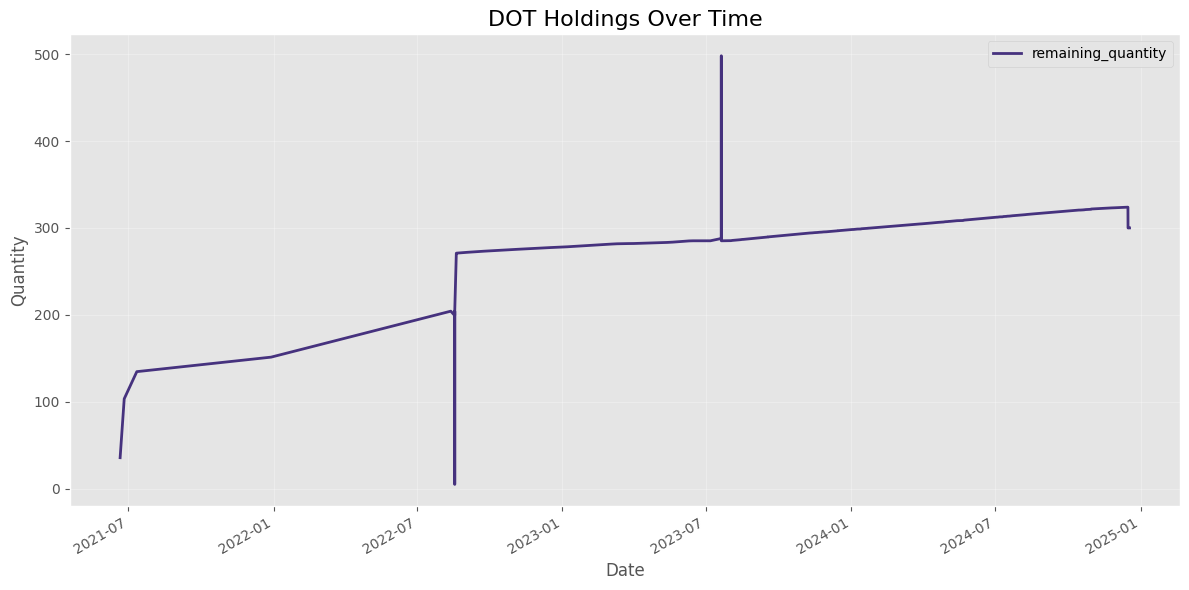

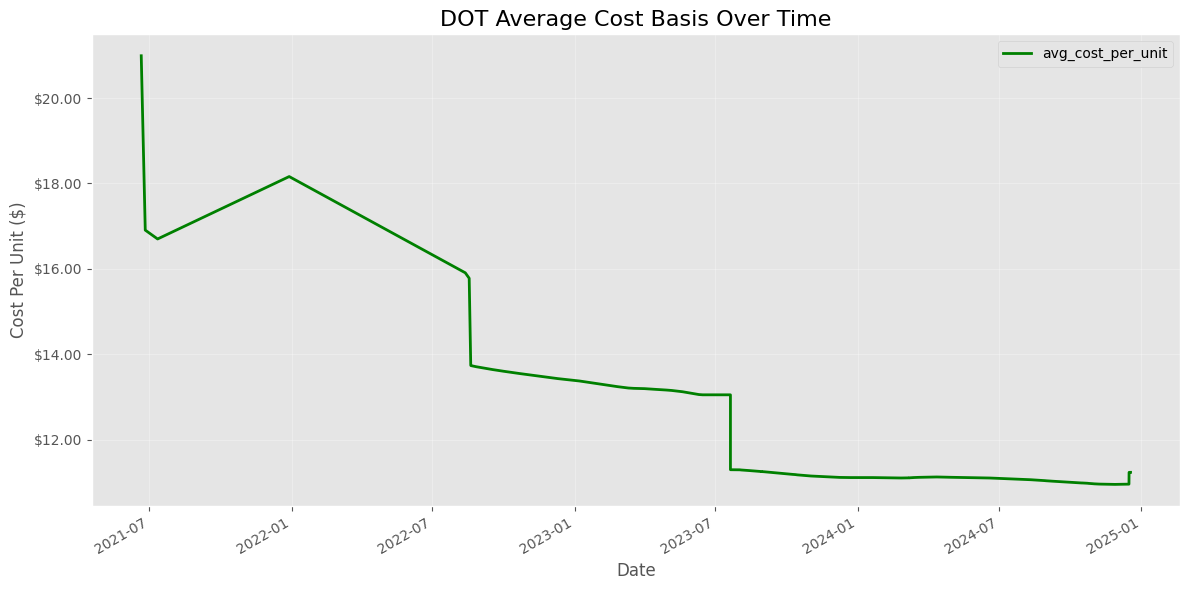

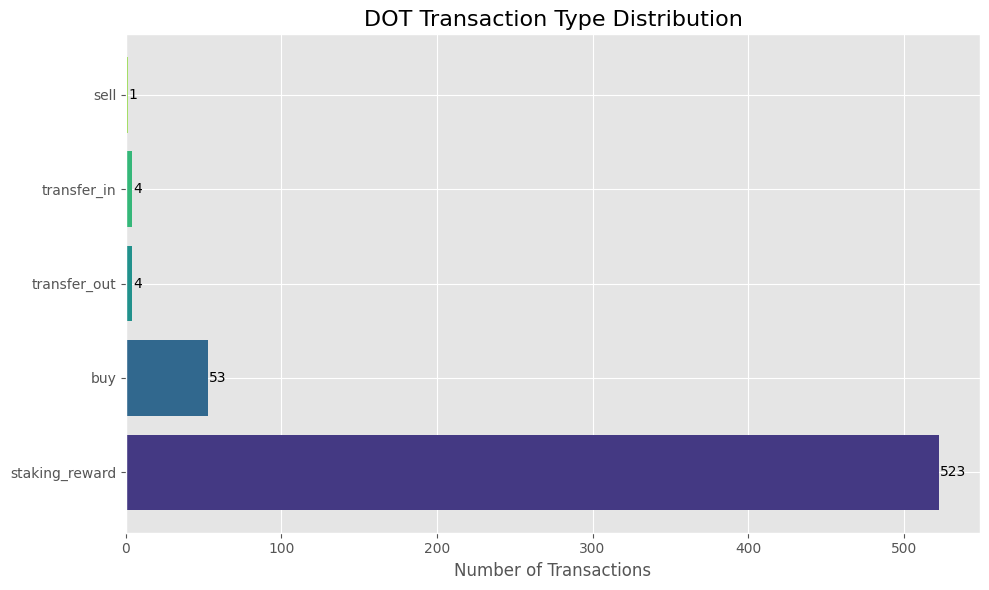

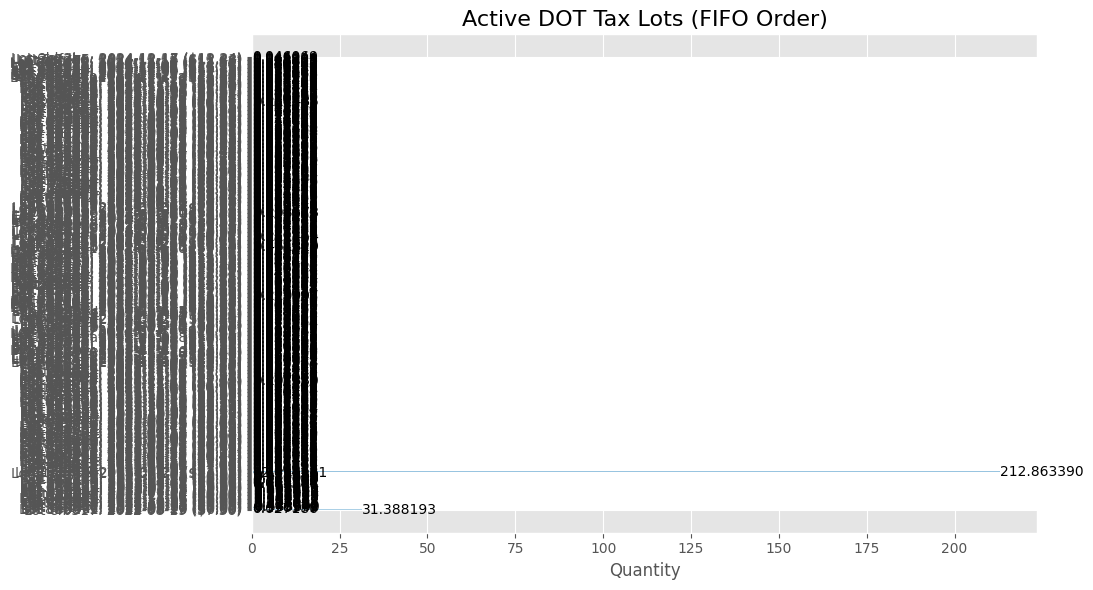

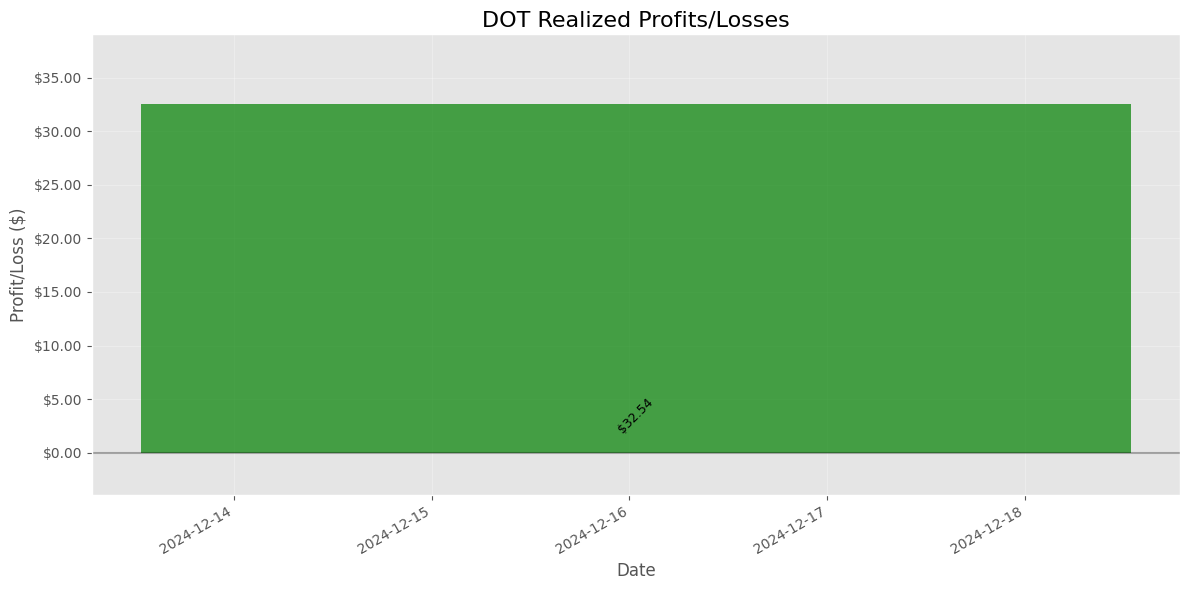

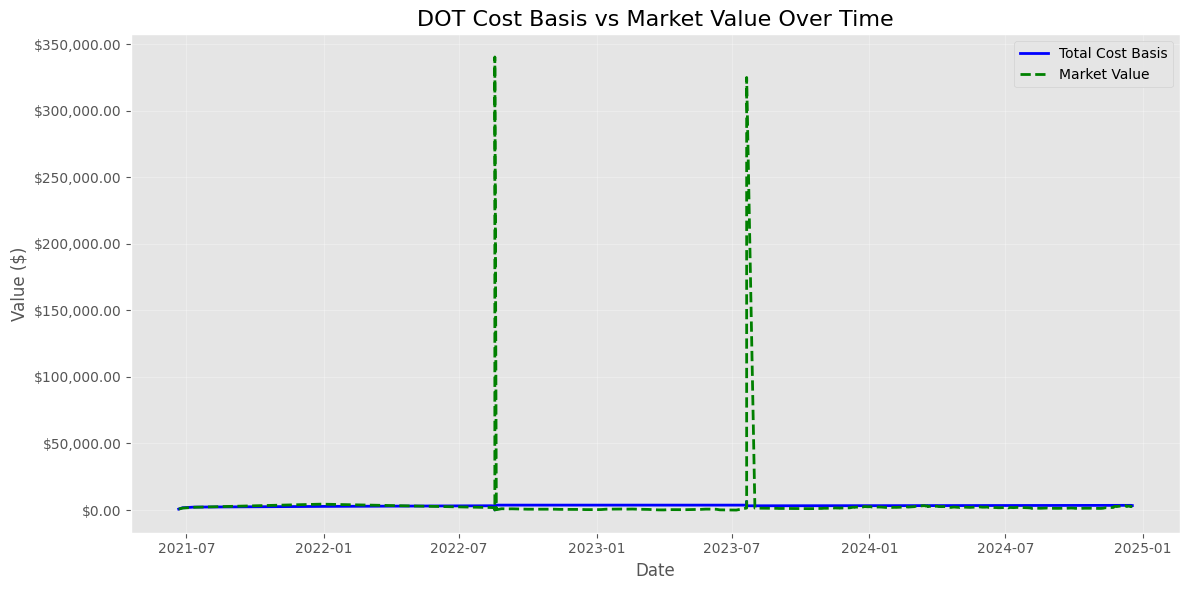

In [35]:
result = analyze_crypto_with_fifo(df, 'DOT')